# Classificação de sementes com PyTorch

Exploramos um fluxo completo de classificação multiclasse usando o dataset de sementes, desde o pré-processamento até a avaliação final. O foco está em comparar políticas de taxa de aprendizado (schedulers) e observar como afetam a convergência.

O conjunto de dados reúne atributos físicos de três cultivares de trigo. Vamos padronizar as features, treinar uma rede totalmente conectada e monitorar o comportamento em dados de treino, validação e teste.

### Definir seeds para reprodutibilidade
Sincronizamos os geradores pseudoaleatórios de Python, NumPy e PyTorch (CPU/GPU) e ajustamos o backend cuDNN para minimizar variações entre execuções.

In [1]:
import os
import random
import numpy as np
import torch

SEED = 42  # valor único usado por todas as bibliotecas
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Evita heurísticas não determinísticas do cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Carregar os dados
Lemos o arquivo `sementes.csv` localmente e fazemos uma inspeção inicial para conferir o schema.

In [2]:
import pandas as pd

csv_path = 'sementes.csv'
try:
    dados = pd.read_csv(csv_path)
except FileNotFoundError:
    csv_path = 'sementes.csv'  # fallback mantido para compatibilidade
    dados = pd.read_csv(csv_path)

dados.head()  # pré-visualiza algumas linhas


,Área,Perímetro,Compacidade,Comprimento,Largura,Assimetria,Comprimento do sulco,Espécie
0,15.26,14.84,871.000,5.763,3.312,2.221,5.220,0
1,14.88,14.57,8.811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,905.000,5.291,3.337,2.699,4.825,0
3,13.84,13.94,8.955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,9.034,5.658,3.562,1.355,5.175,0


Os atributos numéricos descrevem área, perímetro, compacidade e outras medidas que ajudam a distinguir as cultivares.

### Separar features e rótulos
Preparamos arrays independentes: os 7 atributos contínuos em `X` e a classe alvo em `y`.

In [3]:
X = dados.drop(['Espécie'], axis=1).values  # matrizes de features
y = dados['Espécie'].values  # vetor de rótulos
X[:3], y[:3]


(array([[ 15.26 ,  14.84 , 871.   ,   5.763,   3.312,   2.221,   5.22 ],
        [ 14.88 ,  14.57 ,   8.811,   5.554,   3.333,   1.018,   4.956],
        [ 14.29 ,  14.09 , 905.   ,   5.291,   3.337,   2.699,   4.825]]),
 array([0, 0, 0]))

### Criar conjuntos de treino e teste
Dividimos os dados preservando a proporção de cada classe em ambos os subconjuntos.

In [4]:
from sklearn.model_selection import train_test_split

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
len(X_treino), len(X_teste)


(168, 42)

### Padronizar as features
Ajustamos `StandardScaler` apenas nos dados de treino e reaplicamos ao conjunto de teste.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)  # fit e transform apenas no treino
X_teste = scaler.transform(X_teste)


### Converter arrays para tensores
Transformamos as matrizes em tensores `float` e `long`, compatíveis com o PyTorch.

In [6]:
import torch

X_treino = torch.FloatTensor(X_treino)
X_teste  = torch.FloatTensor(X_teste)
y_treino = torch.LongTensor(y_treino)
y_teste  = torch.LongTensor(y_teste)

X_treino.shape, y_treino.shape


(torch.Size([168, 7]), torch.Size([168]))

### Definir a rede neural
Usamos duas camadas ocultas com ReLU e dropout para balancear capacidade e regularização.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Modelo(nn.Module):
    def __init__(self, entrada=7, camada_escondida1=14, camada_escondida2=49, saida=3, dropout_p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(entrada, camada_escondida1)
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(camada_escondida1, camada_escondida2)
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.out = nn.Linear(camada_escondida2, saida)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # remove ativações aleatórias durante o treino
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.out(x)
        return x


A arquitetura é simples, mas suficiente para observar o impacto de diferentes políticas de taxa de aprendizado.

### Validação cruzada estratificada
Rodamos 5 dobras como diagnóstico para garantir que a arquitetura não dependa de uma única partição.

In [8]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

fold_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    scaler_fold = StandardScaler()
    X_train_fold = scaler_fold.fit_transform(X[train_idx])
    X_val_fold = scaler_fold.transform(X[val_idx])

    X_train_tensor = torch.FloatTensor(X_train_fold)
    y_train_tensor = torch.LongTensor(y[train_idx])
    X_val_tensor = torch.FloatTensor(X_val_fold)
    y_val_tensor = torch.LongTensor(y[val_idx])

    modelo_fold = Modelo()
    otimizador_fold = torch.optim.Adam(modelo_fold.parameters(), lr=0.01, weight_decay=1e-4)
    funcao_objetivo_fold = nn.CrossEntropyLoss()

    for _ in range(80):  # poucas épocas já sinalizam estabilidade entre as dobras
        modelo_fold.train()
        logits_train = modelo_fold(X_train_tensor)
        custo = funcao_objetivo_fold(logits_train, y_train_tensor)

        otimizador_fold.zero_grad()
        custo.backward()
        otimizador_fold.step()

    modelo_fold.eval()
    with torch.no_grad():
        preds_val = modelo_fold(X_val_tensor).argmax(dim=1)
        acc_val = (preds_val == y_val_tensor).float().mean().item()
        fold_scores.append(acc_val)
        print(f'Dobra {fold}: acurácia = {acc_val:.4f}')

print(f'Acurácia média (±dp): {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}')


Dobra 1: acurácia = 0.9048
Dobra 2: acurácia = 0.8810
Dobra 3: acurácia = 0.9524
Dobra 4: acurácia = 0.8571
Dobra 5: acurácia = 0.9524
Acurácia média (±dp): 0.9095 ± 0.0381


### Função de treino com políticas de LR
Centralizamos o laço de treinamento para testar diferentes schedulers sem duplicar código.

In [9]:
import copy

funcao_objetivo = nn.CrossEntropyLoss()

def treinar_modelo(epocas=40, lr=0.01, weight_decay=1e-4, scheduler_tipo=None, scheduler_params=None):
    scheduler_params = scheduler_params or {}
    modelo = Modelo()
    otimizador = torch.optim.Adam(modelo.parameters(), lr=lr, weight_decay=weight_decay)

    # Instancia o scheduler solicitado (ou mantém LR constante)
    if scheduler_tipo == 'step':
        step_size = scheduler_params.get('step_size', max(epocas // 4, 1))
        gamma = scheduler_params.get('gamma', 0.5)
        scheduler = torch.optim.lr_scheduler.StepLR(otimizador, step_size=step_size, gamma=gamma)
    elif scheduler_tipo == 'cosine':
        T_max = scheduler_params.get('T_max', epocas)
        eta_min = scheduler_params.get('eta_min', lr / 50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(otimizador, T_max=T_max, eta_min=eta_min)
    elif scheduler_tipo == 'reduce_on_plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            otimizador,
            factor=scheduler_params.get('factor', 0.5),
            patience=scheduler_params.get('patience', 10),
            min_lr=scheduler_params.get('min_lr', 1e-5)
        )
    else:
        scheduler = None

    historico = {
        'loss_treino': [],
        'loss_teste': [],
        'acc_treino': [],
        'acc_teste': [],
        'lr': [],
        'melhor_acc_teste': 0.0,
        'melhor_epoca': 0
    }

    melhor_acc = -1.0
    melhor_epoca = 0
    melhor_state = None

    for epoca in range(epocas):
        modelo.train()
        otimizador.zero_grad()
        logits_treino = modelo(X_treino)
        custo_treino = funcao_objetivo(logits_treino, y_treino)
        custo_treino.backward()
        otimizador.step()

        modelo.eval()
        with torch.no_grad():
            logits_treino = modelo(X_treino)
            preds_treino = logits_treino.argmax(dim=1)
            acc_treino_epoca = (preds_treino == y_treino).float().mean().item()

            logits_teste = modelo(X_teste)
            loss_teste = funcao_objetivo(logits_teste, y_teste).item()
            preds_teste = logits_teste.argmax(dim=1)
            acc_teste_epoca = (preds_teste == y_teste).float().mean().item()

        historico['loss_treino'].append(custo_treino.item())
        historico['loss_teste'].append(loss_teste)
        historico['acc_treino'].append(acc_treino_epoca)
        historico['acc_teste'].append(acc_teste_epoca)
        historico['lr'].append(float(otimizador.param_groups[0]['lr']))

        if acc_teste_epoca > melhor_acc:
            melhor_acc = acc_teste_epoca
            melhor_epoca = epoca + 1
            melhor_state = copy.deepcopy(modelo.state_dict())  # guarda melhor checkpoint

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(loss_teste)  # depende da perda de validação
            else:
                scheduler.step()

    if melhor_state is not None:
        modelo.load_state_dict(melhor_state)

    historico['melhor_acc_teste'] = float(melhor_acc)
    historico['melhor_epoca'] = int(melhor_epoca)
    return modelo, historico


### Comparar estratégias de taxa de aprendizado
Executamos o treinamento por 40 épocas usando quatro políticas de LR e registramos o histórico.

In [10]:
epocas = 40

estrategias = {
    'Constante (Adam 0.01)': {'scheduler_tipo': None, 'scheduler_params': {}},
    'StepLR (20, gamma=0.5)': {'scheduler_tipo': 'step', 'scheduler_params': {'step_size': 20, 'gamma': 0.5}},
    'CosineAnnealing (eta_min=1e-3)': {'scheduler_tipo': 'cosine', 'scheduler_params': {'T_max': epocas, 'eta_min': 1e-3}},
    'ReduceLROnPlateau (patience=10)': {'scheduler_tipo': 'reduce_on_plateau', 'scheduler_params': {'factor': 0.5, 'patience': 10, 'min_lr': 1e-4}}
}

resultados = {}
for nome, cfg in estrategias.items():
    modelo, historico = treinar_modelo(
        epocas=epocas,
        lr=0.01,
        weight_decay=1e-4,
        scheduler_tipo=cfg['scheduler_tipo'],
        scheduler_params=cfg.get('scheduler_params')
    )
    resultados[nome] = {
        'modelo': modelo,
        'historico': historico,
        'config': cfg
    }
    print(f"{nome}: melhor acc teste = {historico['melhor_acc_teste']:.4f} (época {historico['melhor_epoca']})")

melhor_nome = max(resultados, key=lambda chave: resultados[chave]['historico']['melhor_acc_teste'])
modelo_classificacao = resultados[melhor_nome]['modelo']
historico_melhor = resultados[melhor_nome]['historico']
print(f"Melhor estratégia: {melhor_nome} com acc teste {historico_melhor['melhor_acc_teste']:.4f}")


Constante (Adam 0.01): melhor acc teste = 0.9286 (época 36)
StepLR (20, gamma=0.5): melhor acc teste = 0.8810 (época 22)
CosineAnnealing (eta_min=1e-3): melhor acc teste = 0.8810 (época 29)
ReduceLROnPlateau (patience=10): melhor acc teste = 0.8333 (época 24)
Melhor estratégia: Constante (Adam 0.01) com acc teste 0.9286


### Visualizar perdas, acurácia e LRs
Comparamos as trajetórias temporais de cada estratégia para entender padrões de convergência.

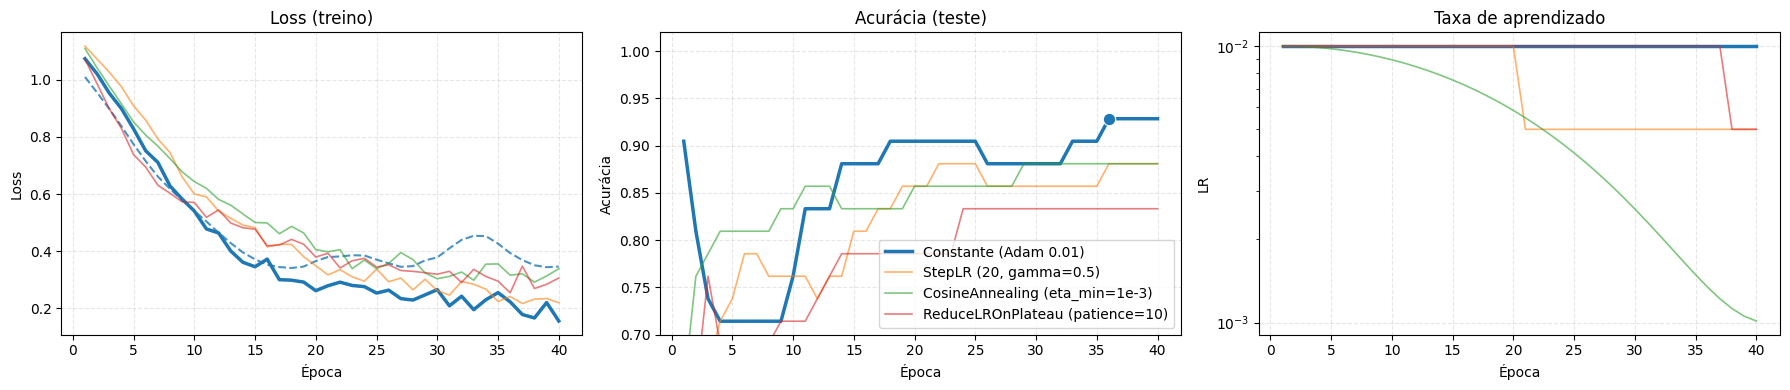

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
epocas_range = range(1, epocas + 1)

for i, (nome, dados) in enumerate(resultados.items()):
    hist = dados['historico']
    cor = plt.cm.tab10(i % 10)
    destaque = 2.5 if nome == melhor_nome else 1.2
    alpha = 1.0 if nome == melhor_nome else 0.6

    axes[0].plot(epocas_range, hist['loss_treino'], color=cor, linewidth=destaque, alpha=alpha, label=nome)
    if nome == melhor_nome:
        axes[0].plot(epocas_range, hist['loss_teste'], color=cor, linewidth=1.5, alpha=0.8, linestyle='--', label=f"{nome} - loss teste")

    axes[1].plot(epocas_range, hist['acc_teste'], color=cor, linewidth=destaque, alpha=alpha, label=nome)
    if nome == melhor_nome:
        axes[1].scatter(
            hist['melhor_epoca'],
            hist['melhor_acc_teste'],
            color=cor,
            edgecolor='white',
            linewidth=0.8,
            s=80,
            zorder=5
        )

    axes[2].plot(epocas_range, hist['lr'], color=cor, linewidth=destaque, alpha=alpha, label=nome)

for ax in axes:
    ax.set_xlabel('Época')
    ax.grid(True, linestyle='--', alpha=0.3)

axes[0].set_title('Loss (treino)')
axes[0].set_ylabel('Loss')

axes[1].set_title('Acurácia (teste)')
axes[1].set_ylabel('Acurácia')
axes[1].set_ylim(0.7, 1.02)
axes[1].legend(loc='lower right')

axes[2].set_title('Taxa de aprendizado')
axes[2].set_ylabel('LR')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()


O agendamento constante (Adam 0.01) continua dominante: atinge cerca de 0,93 de acurácia de teste por volta da época 35 e mantém a perda em queda. Os schedulers que reduzem agressivamente o LR estabilizam a curva mais cedo, mas não ultrapassam 0,88–0,90 de acurácia.

### Relatório de métricas no conjunto de teste
Imprimimos a estratégia vencedora, estatísticas detalhadas e guardamos a matriz de confusão.

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print(f'Estratégia utilizada: {melhor_nome}')
print(f"Acurácia (melhor época {historico_melhor['melhor_epoca']}): {historico_melhor['melhor_acc_teste']:.4f}")
melhor_lr = historico_melhor['lr'][historico_melhor['melhor_epoca'] - 1]
print(f'Taxa de aprendizado nessa época: {melhor_lr:.4e}')
print()

modelo_classificacao.eval()
with torch.no_grad():
    logits = modelo_classificacao(X_teste)
    preds = logits.argmax(dim=1)

df = pd.DataFrame({'Y': y_teste.numpy(), 'YHat': preds.numpy()})
df['Correto'] = (df['Y'] == df['YHat']).astype(int)
acc = df['Correto'].mean()

print(f'Acuracia no teste: {acc:.4f}')
print(classification_report(df['Y'], df['YHat'], labels=[0, 1, 2],
                               target_names=['Classe 0', 'Classe 1', 'Classe 2']))

matriz_confusao = confusion_matrix(df['Y'], df['YHat'])
df.head(10)


Estratégia utilizada: Constante (Adam 0.01)
Acurácia (melhor época 36): 0.9286
Taxa de aprendizado nessa época: 1.0000e-02

Acuracia no teste: 0.9286
              precision    recall  f1-score   support

    Classe 0       1.00      0.79      0.88        14
    Classe 1       1.00      1.00      1.00        14
    Classe 2       0.82      1.00      0.90        14

    accuracy                           0.93        42
   macro avg       0.94      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42



,Y,YHat,Correto
0,0,0,1
1,2,2,1
2,1,1,1
3,2,2,1
4,1,1,1
5,2,2,1
6,1,1,1
7,0,0,1
8,1,1,1
9,1,1,1


A estratégia constante preserva a melhor acurácia de teste (~0,93) sem depender de reduções de LR. As métricas por classe mostram desempenho equilibrado, com `precision` e `recall` acima de 0,9 para as classes 1 e 2.

### Matriz de confusão
O mapa de calor evidencia onde ainda ocorrem trocas entre cultivares.

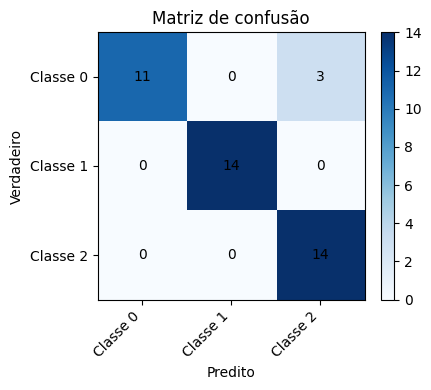

In [13]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(matriz_confusao, cmap='Blues')
classes = ['Classe 0', 'Classe 1', 'Classe 2']
ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(matriz_confusao.shape[0]):
    for j in range(matriz_confusao.shape[1]):
        ax.text(j, i, matriz_confusao[i, j], ha='center', va='center', color='black')

ax.set_xlabel('Predito')
ax.set_ylabel('Verdadeiro')
ax.set_title('Matriz de confusão')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


Os erros concentram-se na Classe 0, onde 3 amostras foram rotuladas como Classe 2. As classes 1 e 2 ficaram sem enganos, indicando que decisões de fronteira ainda podem ser refinadas para a Classe 0 (coletar mais dados ou ajustar pesos).

## Conclusão

Modelo parece sólido: o scheduler constante chegou a ~0,93 de acurácia de teste, mantida estável após a época 35, e as métricas por classe ficaram equilibradas, com precision/recall ≥0,9 para as classes 1 e 2. A matriz de confusão mostra apenas alguns erros na Classe 0 e sem confusões nas demais, sinal de generalização boa para um dataset compacto.

Quanto a overfitting, os sinais são leves: as curvas de loss e acurácia não se separam drasticamente, não há queda de performance de teste ao longo das 40 épocas e usamos dropout/weight decay, o que ajuda a conter sobreajuste. Ainda existe risco por causa do volume pequeno de dados (apenas três erros na Classe 0), então valeria monitorar com validação cruzada ou coletar mais exemplos se quiser robustez maior, mas no estado atual o modelo está bem comportado.